<a href="https://colab.research.google.com/github/fjadidi2001/Cyber-Attack-Detection/blob/main/CyberAttackDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FlowChart

In [2]:
from graphviz import Digraph

dot = Digraph(comment='Cyber Attack Detection Flowchart')
dot.node('A', 'Start')
dot.node('B', 'Define Problem & Scope')
dot.node('C', 'Collect Dataset')
dot.node('D', 'Preprocess Data')
dot.node('E', 'Perform EDA')
dot.node('F', 'Select Model')
dot.node('G', 'Train Model')
dot.node('H', 'Evaluate Model')
dot.node('I', 'Optimize Model')
dot.node('J', 'Deploy Model')
dot.node('K', 'Monitor & Retrain')
dot.node('L', 'End')

dot.edges(['AB', 'BC', 'CD', 'DE', 'EF', 'FG', 'GH', 'HJ', 'JK', 'KL'])
dot.edge('H', 'I', label='If performance poor')
dot.edge('I', 'G', label='Retrain')

dot.render('flowchart', format='png', view=True)

'flowchart.png'

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
from google.colab import drive
from IPython.display import Image
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import psutil
import warnings
warnings.filterwarnings('ignore')

# Function to monitor memory usage
def print_memory_usage(step_name):
    process = psutil.Process()
    mem_info = process.memory_info()
    print(f"{step_name} - Memory usage: {mem_info.rss / 1024**2:.2f} MB")

# Step 1: Setup and Extract Dataset
def setup_and_extract():
    print("\nStep 1: Setup and Extract Dataset")
    # Mount Google Drive
    drive.mount('/content/drive', force_remount=True)

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Paths
    zip_path = '/content/drive/MyDrive/network-intrusion-dataset.zip'
    extract_dir = '/content/cicids2017/'

    # Unzip the dataset
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
        print("Dataset extracted successfully.")
    except FileNotFoundError:
        print(f"Error: Zip file not found at {zip_path}. Please check the path.")
        return None, None

    # Find CSV files
    csv_files = []
    for root, _, files in os.walk(extract_dir):
        for file in files:
            if file.endswith('.csv'):
                csv_files.append(os.path.join(root, file))
    print("Found CSV files:")
    for file in csv_files:
        print(f"  {file}")

    if not csv_files:
        print("Error: No CSV files found in", extract_dir)
        return None, None

    print_memory_usage("Step 1")
    return csv_files, extract_dir

csv_files, extract_dir = setup_and_extract()
if csv_files is None:
    raise SystemExit("Stopping due to error in Step 1.")


Step 1: Setup and Extract Dataset
Mounted at /content/drive
Using device: cuda
Dataset extracted successfully.
Found CSV files:
  /content/cicids2017/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
  /content/cicids2017/Tuesday-WorkingHours.pcap_ISCX.csv
  /content/cicids2017/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
  /content/cicids2017/Wednesday-workingHours.pcap_ISCX.csv
  /content/cicids2017/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
  /content/cicids2017/Friday-WorkingHours-Morning.pcap_ISCX.csv
  /content/cicids2017/Monday-WorkingHours.pcap_ISCX.csv
  /content/cicids2017/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
Step 1 - Memory usage: 592.70 MB


In [2]:
# Step 2: Load and Combine Datasets
def load_and_combine_data(csv_files):
    print("\nStep 2: Load and Combine Datasets")
    keep_cols = [' Destination Port', ' Flow Duration', ' Total Fwd Packets',
                 ' Total Backward Packets', 'Flow Bytes/s', ' Label']
    data_frames = []

    for file in csv_files:
        try:
            chunks = pd.read_csv(file, encoding='latin1', low_memory=False,
                                usecols=keep_cols, chunksize=100000)
            for chunk in chunks:
                # Optimize data types
                for col in chunk.select_dtypes(include=['int64']).columns:
                    chunk[col] = chunk[col].astype('int32')
                for col in chunk.select_dtypes(include=['float64']).columns:
                    chunk[col] = chunk[col].astype('float32')
                data_frames.append(chunk)
        except Exception as e:
            print(f"Error loading {file}: {e}")

    if not data_frames:
        print("Error: No data loaded.")
        return None

    df = pd.concat(data_frames, ignore_index=True)
    print(f"Dataset shape: {df.shape}")
    print_memory_usage("Step 2")
    return df

df = load_and_combine_data(csv_files)
if df is None:
    raise SystemExit("Stopping due to error in Step 2.")


Step 2: Load and Combine Datasets
Dataset shape: (2830743, 6)
Step 2 - Memory usage: 761.77 MB



Step 3: Initial Data Inspection

First 5 rows:
    Destination Port   Flow Duration   Total Fwd Packets  \
0              54865               3                   2   
1              55054             109                   1   
2              55055              52                   1   
3              46236              34                   1   
4              54863               3                   2   

    Total Backward Packets  Flow Bytes/s   Label  
0                        0  4.000000e+06  BENIGN  
1                        1  1.100917e+05  BENIGN  
2                        1  2.307692e+05  BENIGN  
3                        1  3.529412e+05  BENIGN  
4                        0  4.000000e+06  BENIGN  

Column names:
[' Destination Port', ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', 'Flow Bytes/s', ' Label']

Data types:
 Destination Port            int32
 Flow Duration               int32
 Total Fwd Packets           int32
 Total Backward Packets      int32
Fl

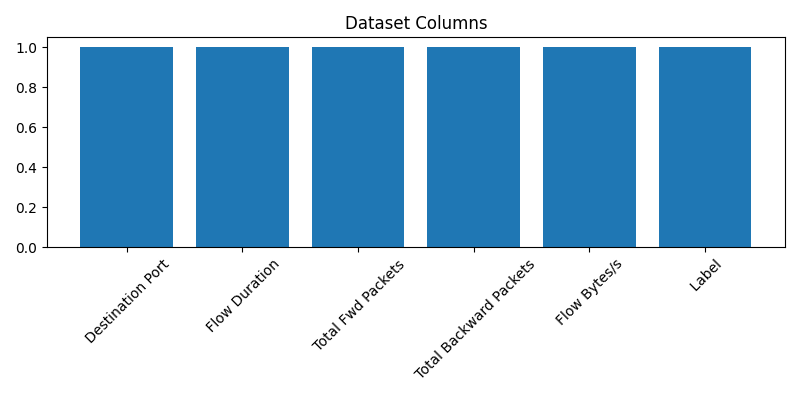

Step 3 - Memory usage: 758.30 MB


In [3]:
# Step 3: Initial Data Inspection
def inspect_data(df):
    print("\nStep 3: Initial Data Inspection")
    print("\nFirst 5 rows:")
    print(df.head())
    print("\nColumn names:")
    print(df.columns.tolist())
    print("\nData types:")
    print(df.dtypes)
    print("\nBasic statistics:")
    print(df.describe())

    # Visualize columns
    plt.figure(figsize=(8, 4))
    plt.bar(range(len(df.columns)), [1] * len(df.columns))
    plt.xticks(range(len(df.columns)), df.columns, rotation=45)
    plt.title("Dataset Columns")
    plt.tight_layout()
    plt.savefig('columns.png')
    plt.close()

    # Display plot
    display(Image('columns.png'))
    print_memory_usage("Step 3")

inspect_data(df)


Step 4: Check for Missing Values

Missing values per column:
Flow Bytes/s    1358
dtype: int64


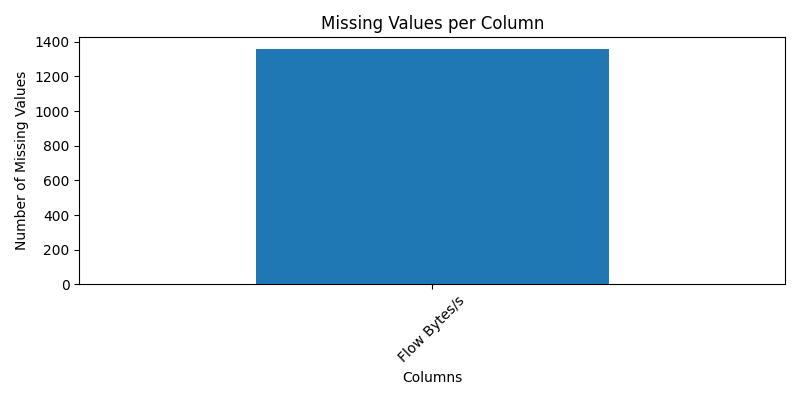

Step 4 - Memory usage: 759.39 MB


In [4]:
# Step 4: Check for Missing Values
def check_missing_values(df):
    print("\nStep 4: Check for Missing Values")
    missing_values = df.isnull().sum()
    print("\nMissing values per column:")
    print(missing_values[missing_values > 0])

    # Visualize missing values
    if missing_values[missing_values > 0].empty:
        print("No missing values to visualize.")
    else:
        plt.figure(figsize=(8, 4))
        missing_values[missing_values > 0].plot(kind='bar')
        plt.title("Missing Values per Column")
        plt.xlabel("Columns")
        plt.ylabel("Number of Missing Values")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig('missing_values.png')
        plt.close()
        display(Image('missing_values.png'))

    print_memory_usage("Step 4")
    return missing_values

missing_values = check_missing_values(df)

In [5]:
# Step 5: Handle Missing Values
def handle_missing_values(df):
    print("\nStep 5: Handle Missing Values")
    # Replace inf values with NaN
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Impute numerical columns with median
    numerical_cols = df.select_dtypes(include=['float32', 'int32']).columns
    if not numerical_cols.empty:
        imputer = SimpleImputer(strategy='median')
        df[numerical_cols] = imputer.fit_transform(df[numerical_cols])
    else:
        print("Error: No numerical columns found for imputation.")

    print("\nMissing values after imputation:")
    print(df.isnull().sum().sum())
    print_memory_usage("Step 5")
    return df

df = handle_missing_values(df)


Step 5: Handle Missing Values

Missing values after imputation:
0
Step 5 - Memory usage: 748.93 MB



Step 6: Analyze Class Distribution

Class distribution:
Label
0    2273097
1     557646
Name: count, dtype: int64


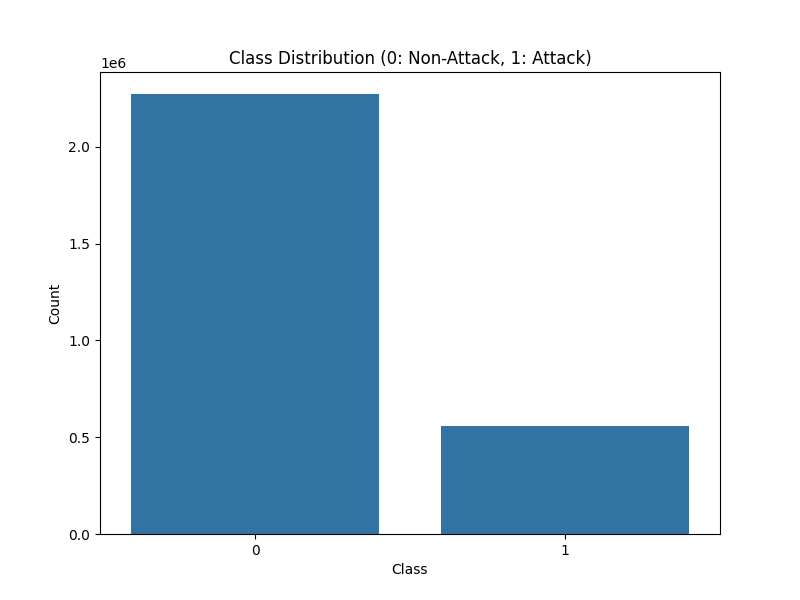


Attack types distribution:
 Label
DoS Hulk                        231073
PortScan                        158930
DDoS                            128027
DoS GoldenEye                    10293
FTP-Patator                       7938
SSH-Patator                       5897
DoS slowloris                     5796
DoS Slowhttptest                  5499
Bot                               1966
Web Attack ï¿½ Brute Force        1507
Web Attack ï¿½ XSS                 652
Infiltration                        36
Web Attack ï¿½ Sql Injection        21
Heartbleed                          11
Name: count, dtype: int64


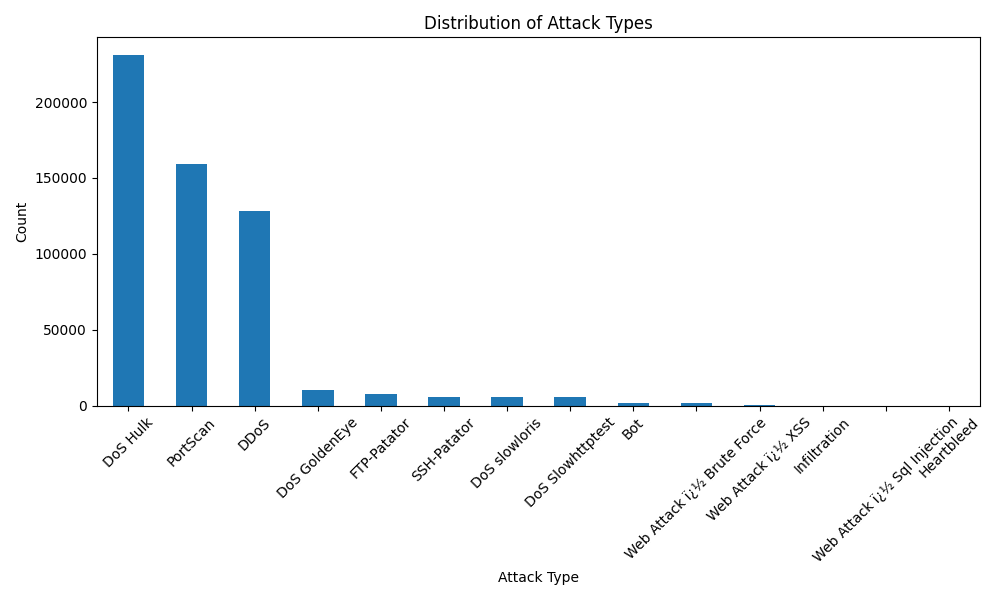

Step 6 - Memory usage: 796.62 MB


In [6]:
# Step 6: Analyze Class Distribution
def analyze_class_distribution(df):
    print("\nStep 6: Analyze Class Distribution")
    # Map labels
    df['Label'] = df[' Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)
    class_counts = df['Label'].value_counts()
    print("\nClass distribution:")
    print(class_counts)

    # Visualize class distribution
    plt.figure(figsize=(8, 6))
    sns.countplot(x='Label', data=df)
    plt.title("Class Distribution (0: Non-Attack, 1: Attack)")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.savefig('class_distribution.png')
    plt.close()
    display(Image('class_distribution.png'))

    # Attack type distribution
    attack_types = df[df['Label'] == 1][' Label'].value_counts()
    print("\nAttack types distribution:")
    print(attack_types)

    plt.figure(figsize=(10, 6))
    attack_types.plot(kind='bar')
    plt.title("Distribution of Attack Types")
    plt.xlabel("Attack Type")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('attack_types_distribution.png')
    plt.close()
    display(Image('attack_types_distribution.png'))

    print_memory_usage("Step 6")
    return df

df = analyze_class_distribution(df)

In [7]:
# Step 7: Feature Correlation Analysis
def correlation_analysis(df):
    print("\nStep 7: Feature Correlation Analysis")
    # Sample 10,000 rows
    sample_df = df.sample(n=10000, random_state=42)
    numerical_cols = sample_df.select_dtypes(include=['float32', 'int32']).columns
    if numerical_cols.empty:
        print("Error: No numerical columns found for correlation.")
        return

    corr_matrix = sample_df[numerical_cols].corr()
    print("\nCorrelation matrix (sample):")
    print(corr_matrix)

    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
    plt.title("Correlation Matrix (Sampled Data)")
    plt.tight_layout()
    plt.savefig('correlation_matrix.png')
    plt.close()
    display(Image('correlation_matrix.png'))

    print_memory_usage("Step 7")

correlation_analysis(df)


Step 7: Feature Correlation Analysis
Error: No numerical columns found for correlation.
